# Evaluate Integrator Accuracy

# IAS15

In [8]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle
import rebound

from jorbit.utils.states import SystemState
from jorbit.accelerations import newtonian_gravity

from jorbit.integrators import (
    IAS15IntegratorState,
    IAS15Helper,
    initialize_ias15_integrator_state,
    ias15_evolve,
)

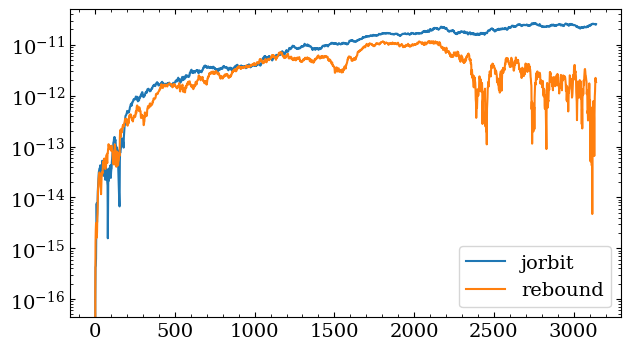

In [40]:
n_orbits = 500
times = jnp.linspace(0.0, 2 * jnp.pi * n_orbits, n_orbits * 4 + 1)

initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)
acc_func = jax.tree_util.Partial(newtonian_gravity)
a0 = acc_func(initial_system_state)

reb = initialize_ias15_integrator_state(a0=a0)

jorbit_positions = ias15_evolve(
    initial_system_state=initial_system_state,
    acceleration_func=acc_func,
    times=times,
    initial_integrator_state=reb,
    n_steps=50,
)[0][:, 1]

sim = rebound.Simulation()
sim.add(m=1.0)
sim.add(m=0.0)
sim.particles[1].x = 1.0
sim.particles[1].vy = 1.0
rebound_positions = []
for time in times:
    sim.integrate(time)
    rebound_positions.append(sim.particles[1].xyz)
rebound_positions = jnp.array(rebound_positions)


target_positions = jnp.tile(
    jnp.array([[1.0, 0, 0], [0, 1.0, 0], [-1.0, 0, 0], [0.0, -1, 0]]), (n_orbits, 1)
)
jorbit_errs = jnp.linalg.norm(jorbit_positions[:-1] - target_positions, axis=-1)
rebound_errs = jnp.linalg.norm(rebound_positions[:-1] - target_positions, axis=-1)

fig, ax = plt.subplots()
ax.plot(times[:-1], jorbit_errs, label="jorbit")
ax.plot(times[:-1], rebound_errs, label="rebound")
ax.set_yscale("log")
ax.legend()

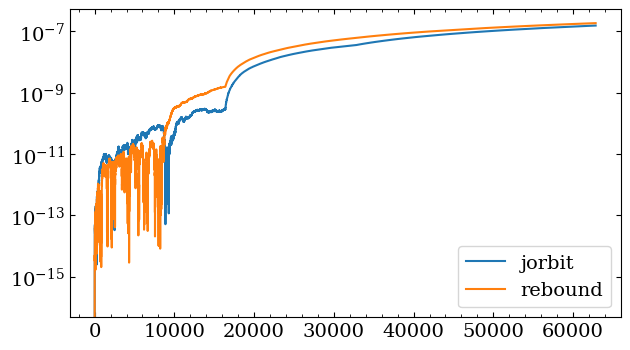

In [39]:
n_orbits = 10_000
times = jnp.linspace(0.0, 2 * jnp.pi * n_orbits, n_orbits * 4 + 1)

initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)
acc_func = jax.tree_util.Partial(newtonian_gravity)
a0 = acc_func(initial_system_state)

reb = initialize_ias15_integrator_state(a0=a0)

jorbit_positions = ias15_evolve(
    initial_system_state=initial_system_state,
    acceleration_func=acc_func,
    times=times,
    initial_integrator_state=reb,
    n_steps=50,
)[0][:, 1]

sim = rebound.Simulation()
sim.add(m=1.0)
sim.add(m=0.0)
sim.particles[1].x = 1.0
sim.particles[1].vy = 1.0
rebound_positions = []
for time in times:
    sim.integrate(time)
    rebound_positions.append(sim.particles[1].xyz)
rebound_positions = jnp.array(rebound_positions)


target_positions = jnp.tile(
    jnp.array([[1.0, 0, 0], [0, 1.0, 0], [-1.0, 0, 0], [0.0, -1, 0]]), (n_orbits, 1)
)
jorbit_errs = jnp.linalg.norm(jorbit_positions[:-1] - target_positions, axis=-1)
rebound_errs = jnp.linalg.norm(rebound_positions[:-1] - target_positions, axis=-1)

fig, ax = plt.subplots()
ax.plot(times[:-1], jorbit_errs, label="jorbit")
ax.plot(times[:-1], rebound_errs, label="rebound")
ax.set_yscale("log")
ax.legend()

[None]

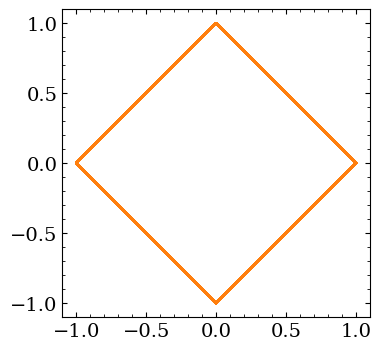

In [23]:
fig, ax = plt.subplots()
ax.plot(jorbit_positions[:, 0], jorbit_positions[:, 1], label="jorbit")
ax.plot(rebound_positions[:, 0], rebound_positions[:, 1], label="rebound")
ax.set(aspect="equal")

## RK4

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle

from jorbit.utils.states import SystemState
from jorbit.integrators import RK4IntegratorState
from jorbit.accelerations import newtonian_gravity
from jorbit.integrators import rk4_evolve

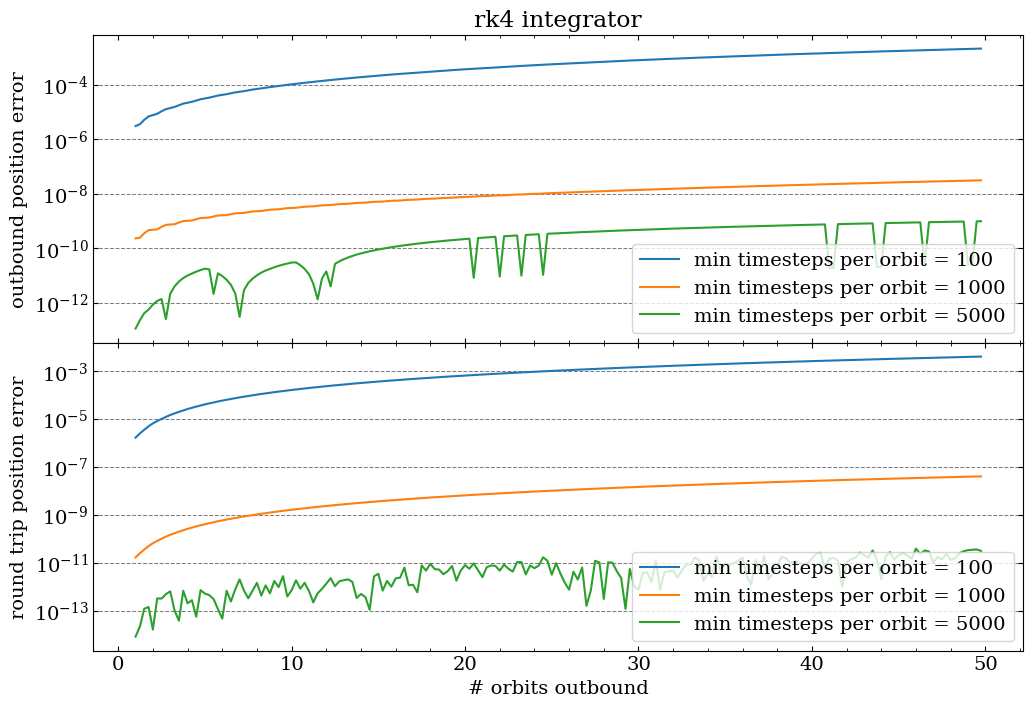

In [2]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
n_orbits_outbound = jnp.arange(1, 50, 0.25)
acc_func = jax.tree_util.Partial(newtonian_gravity)

outbound_target_positions = cycle(
    [
        jnp.array([1.0, 0.0, 0.0]),
        jnp.array([0.0, 1.0, 0.0]),
        jnp.array([-1.0, 0.0, 0.0]),
        jnp.array([0.0, -1.0, 0.0]),
    ]
)

for min_timesteps_per_orbit in [100, 1_000, 5_000]:
    known_period = 2 * jnp.pi
    dt = known_period / min_timesteps_per_orbit

    initial_integrator_state = RK4IntegratorState(dt=dt)

    outbound_position_errors = []
    round_trip_position_errors = []
    for n_orbits in n_orbits_outbound:
        target = next(outbound_target_positions)
        t_out = 2 * jnp.pi * n_orbits
        new_system_state, new_integrator_state = rk4_evolve(
            initial_system_state,
            acc_func,
            t_out,
            initial_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )
        outbound_position_errors.append(
            jnp.linalg.norm(new_system_state.positions[1] - target)
        )

        new_system_state, new_integrator_state = rk4_evolve(
            new_system_state,
            acc_func,
            0.0,
            new_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )
        round_trip_position_errors.append(
            jnp.linalg.norm(new_system_state.positions[1] - jnp.array([1.0, 0.0, 0.0]))
        )

    ax[0].plot(
        n_orbits_outbound,
        outbound_position_errors,
        label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
    )
    ax[1].plot(
        n_orbits_outbound,
        round_trip_position_errors,
        label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
    )

ax[0].set(
    ylabel="outbound position error",
    yscale="log",
    title="rk4 integrator",
)
ax[0].legend()
ax[0].grid(
    which="major", axis="y", color="black", linestyle="--", linewidth=0.75, alpha=0.5
)

ax[1].set(
    xlabel="# orbits outbound",
    ylabel="round trip position error",
    yscale="log",
)
ax[1].legend()
ax[1].grid(
    which="major", axis="y", color="black", linestyle="--", linewidth=0.75, alpha=0.5
)

plt.subplots_adjust(hspace=0.0)

## Leapfrog

In [3]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from itertools import cycle

from jorbit.utils.states import SystemState
from jorbit.integrators import LeapfrogIntegratorState
from jorbit.accelerations import newtonian_gravity

from jorbit.integrators import yoshida_step, leapfrog_evolve
from jorbit.data.constants import Y4_C, Y4_D, Y6_C, Y6_D, Y8_C, Y8_D

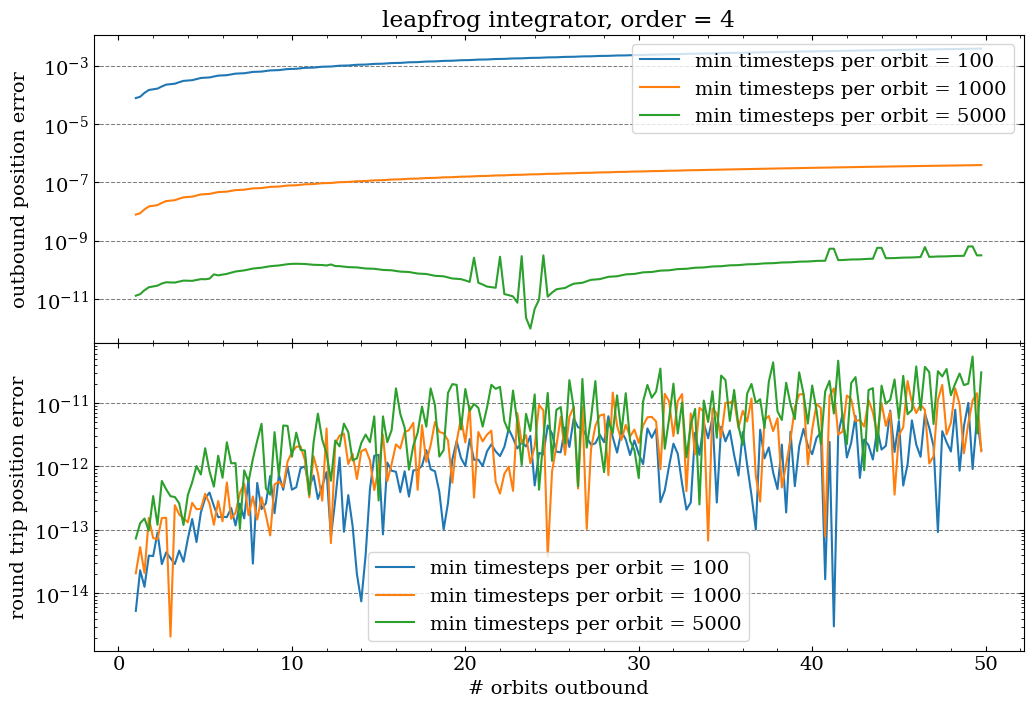

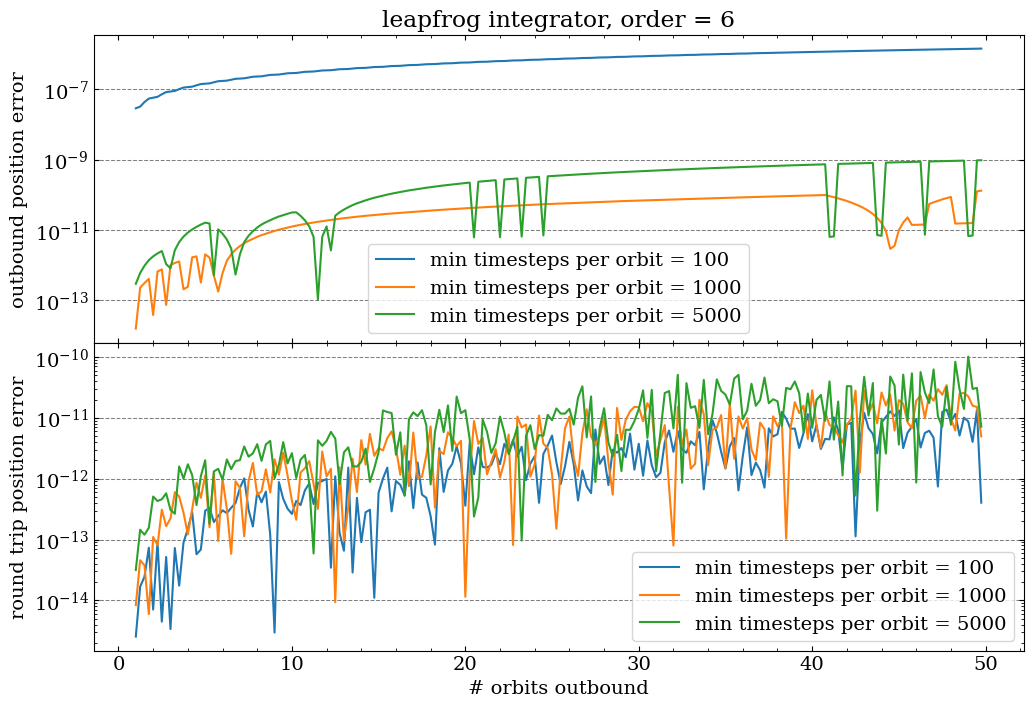

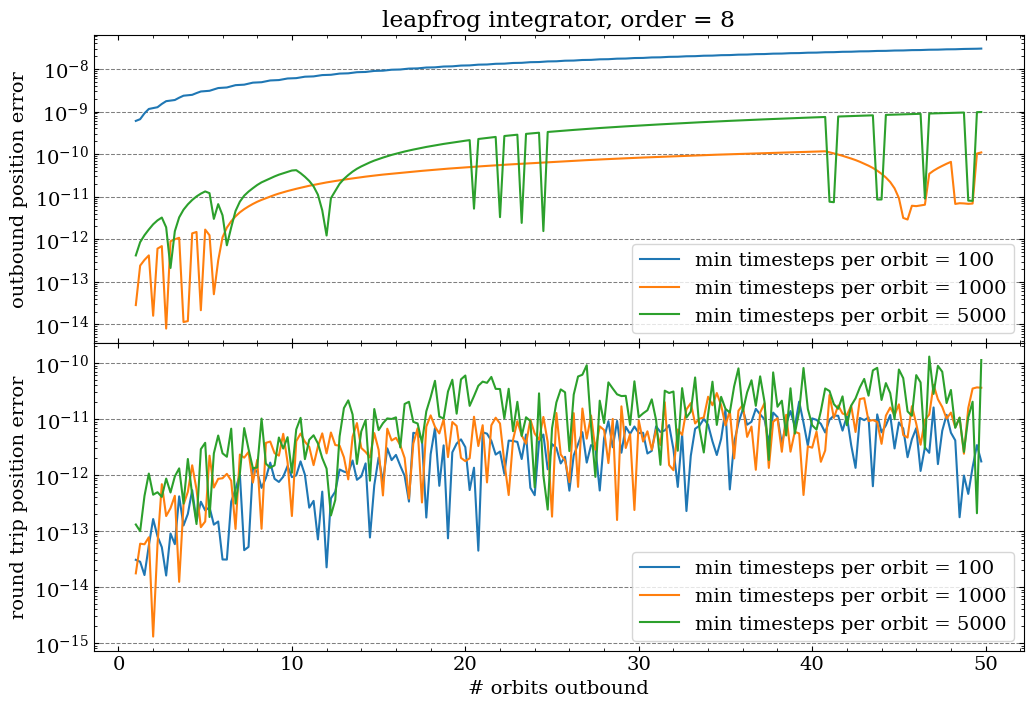

In [4]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)


for order in [4, 6, 8]:
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    n_orbits_outbound = jnp.arange(1, 50, 0.25)
    acc_func = jax.tree_util.Partial(newtonian_gravity)
    outbound_target_positions = cycle(
        [
            jnp.array([1.0, 0.0, 0.0]),
            jnp.array([0.0, 1.0, 0.0]),
            jnp.array([-1.0, 0.0, 0.0]),
            jnp.array([0.0, -1.0, 0.0]),
        ]
    )

    for min_timesteps_per_orbit in [100, 1_000, 5_000]:
        known_period = 2 * jnp.pi
        dt = known_period / min_timesteps_per_orbit

        if order == 4:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y4_C, d_coeff=Y4_D
            )
        elif order == 6:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y6_C, d_coeff=Y6_D
            )
        elif order == 8:
            initial_integrator_state = LeapfrogIntegratorState(
                dt=dt, c_coeff=Y8_C, d_coeff=Y8_D
            )

        outbound_position_errors = []
        round_trip_position_errors = []
        for n_orbits in n_orbits_outbound:
            target = next(outbound_target_positions)
            t_out = 2 * jnp.pi * n_orbits
            new_system_state, new_integrator_state = leapfrog_evolve(
                initial_system_state,
                acc_func,
                t_out,
                initial_integrator_state,
                int(t_out / initial_integrator_state.dt) + 1,
            )
            outbound_position_errors.append(
                jnp.linalg.norm(new_system_state.positions[1] - target)
            )

            new_system_state, new_integrator_state = leapfrog_evolve(
                new_system_state,
                acc_func,
                0.0,
                new_integrator_state,
                int(t_out / initial_integrator_state.dt) + 1,
            )
            round_trip_position_errors.append(
                jnp.linalg.norm(
                    new_system_state.positions[1] - jnp.array([1.0, 0.0, 0.0])
                )
            )

        ax[0].plot(
            n_orbits_outbound,
            outbound_position_errors,
            label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
        )
        ax[1].plot(
            n_orbits_outbound,
            round_trip_position_errors,
            label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
        )

    ax[0].set(
        ylabel="outbound position error",
        yscale="log",
        title=f"leapfrog integrator, order = {order}",
    )
    ax[0].legend()
    ax[0].grid(
        which="major",
        axis="y",
        color="black",
        linestyle="--",
        linewidth=0.75,
        alpha=0.5,
    )

    ax[1].set(
        xlabel="# orbits outbound",
        ylabel="round trip position error",
        yscale="log",
    )
    ax[1].legend()
    ax[1].grid(
        which="major",
        axis="y",
        color="black",
        linestyle="--",
        linewidth=0.75,
        alpha=0.5,
    )

    plt.subplots_adjust(hspace=0.0)

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jorbit.integrators.ias15 import add_cs

jax.make_jaxpr(add_cs)(100.001, 0.002, 1e-5)

{ lambda ; a:f64[] b:f64[] c:f64[]. let
    d:f64[] e:f64[] = pjit[
      name=add_cs
      jaxpr={ lambda ; f:f64[] g:f64[] h:f64[]. let
          i:f64[] = sub h g
          j:f64[] = add f i
          k:f64[] = sub j f
          l:f64[] = sub k i
        in (j, l) }
    ] a b c
  in (d, e) }